# cdpi : Causal Discovery Python Implementation

## Constraint-based Algorithm_cpc

### Note : Conservative PC Algorithm

#### Pseudo Code

**\[Assumption\]**


- No hidden confounder Assumption
- Markov Causal Assumption
- Adjacency-Faithfulness Assumption❗

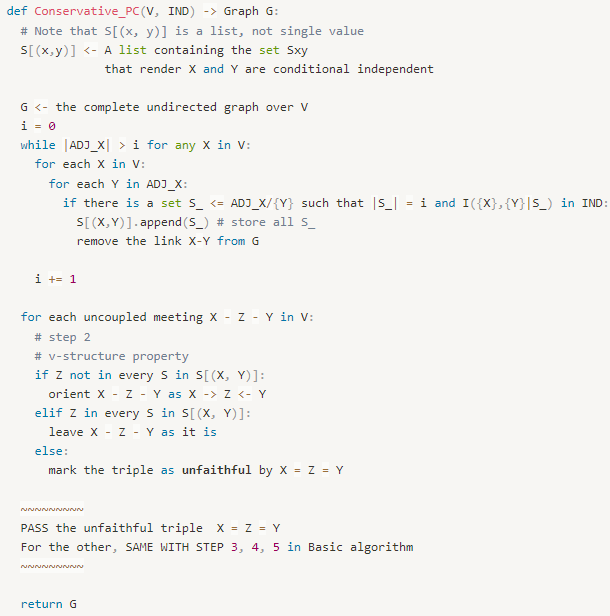 [6]

❓ What is 'Basic algorithm'? ⇒ See [Constraint-based Algorithm_basic](https://colab.research.google.com/drive/1Rrpdw1IlPNKN_yVqc1ZSFx_fzKfHdDtD?usp=sharing)

#### Adjacency-Faithfulness and Orientation-Faithfulness

As you can see in the implementation of Basic algorithm and PC algorithm, p-independence information, IND, is used only to configure skeleton and to find v-structure in step 1 and 2. The remaining steps rely solely on the definition of the DAG and the fact that a given uncoupled triple is not a v-structure. 

In this context, the faithfulness assumption can be seen as consisting of two distinct assumptions : one related to the construction of the skeleton and the other related to the identification of v-structure. Let call the former Adjacency-Faithfulness, because it is related to adjacency between vertexes :

> **Adjacency-Faithfulness**  
> if $X$ and $Y$ are adjacent in DAG G, then $X$ and $Y$ are dependent conditional on any subset of $V/\{X, Y\}$

And let call the latter Orientation-Faithfulness, because it is related to orientation of uncoupled triple :

> **Orientation-Faithfulness**  
> Let (X, Y, Z) be any uncoupled triple in DAG G.  
> (1)  if $X$ → $Z$ ← $Y$, then $X$ and $Y$ are dependent given any subset of $V\{X,Y\}$ that contains $Z$.  
> (2)  Otherwise, $X$ and $Y$ are dependent conditional on any subset of $V\{X,Y\}$ that does not contains $Z$.

The Basic and PC algorithms assume both of these faithfulness. **However, these two assumptions do not always hold, and even if Adjacency-Faithfulness holds, Orientation-Faithfulness may not holds**. For example, consider the following cases.

$G:X\rightarrow Y→ Z \\IND : X \perp_pZ\ \&\ X\perp_pZ|Y$

In this case, Adjacency-Faithfulness holds, but Orientation-Faithfulness is not satisfied. This is because Y is not only included in some conditions that render X and Z are conditional independent and but also excluded in other conditions. Therefore, the skeleton of (X, Y, Z) can be indentified, but the orientation is not determined.

**The problem is that Basic algorithm and PC algorithm only check $X \perp_pZ$ and do not further check the conditonal independence between X and Z**. So they orient the triple X-Y-Z as X → Y ← Z. In order to prevent error when Orientation-Faithfulness is not satisfied, (orientation) unfaithful triple must be dealt with separately. **It is the main idea of Conservative PC Algorithm**. [6]

#### Soundness & Completeness of Conservative PC algorithm

If both faithfulness assumption holds, Conservative PC algorithm is same with PC algorithm. Therefore the result is **sound** and **complete**. 

If Orientation-Faithfulness is not satisfied, the link in the result is **sound** and **complete** but the edge is only **sound**.

### Implementation

❗ We do not need to change step 4, because it uses only the definition of DAG.

❗ In step 1, We only need to delete the code `break`

❗ In step 3 and 5, We only need to add the code `if (x,z,y) in self.unfaithful_triple : continue`

#### STEP 0 & 1 : Find Skeleton by relation of adjacency and d-separation ( = p-independence in practice)

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from itertools import combinations, chain
from collections import defaultdict

In [19]:
def identify_skeleton_from_full_link_graph_in_cpc(self, data, test_kwarg):
    self.ptn = pattern()
    self.ptn.add_vertex(list(data.columns))

    self.p_independence_set = defaultdict(set)
    self.p_independence_set = defaultdict(lambda: defaultdict(set))
    self.ptn.full_link()

    adj = {x : self.ptn.adjacent(x) for x in self.ptn.vertex}
    
    i = 0
    while any(i < len(adj[x]) for x in adj.keys()):
        for x in self.ptn.vertex:
            adj_x = adj[x]

            for y in adj_x:
                adj_x_not_y = list(adj_x - {y})
                power_set = combinations(adj_x_not_y, i)
                for subset in power_set:
                    if self.test(data, {x}, {y}, set(subset), **test_kwarg):
                        self.p_independence_set[x][y]
                        self.p_independence_set[y][x] = self.p_independence_set[x][y]
                        self.p_independence_set[x][y].add(subset)

                        self.ptn.remove_links([(x, y)])
                        # Do NOT break
            
            adj[x] = self.ptn.adjacent(x)

        i += 1

#### STEP 2 : Find V-structure with checking Orientation-faithfulness

In [20]:
def identify_v_structure_with_adjacency_faithfulness(self):
    uncoupled_triple = deque()
    self.unfaithful_triple = set()

    for x in self.ptn.link.keys():
        for z in self.ptn.link[x].keys():
            for y in self.ptn.link[z].keys():
                if x != y and not self.ptn.is_adjacent(x, y): 
                    # Check Orientation-faithfulness
                    if all(z not in subset for subset in self.p_independence_set[x][y]) : uncoupled_triple.append((x, y, z))
                    elif all(z in subset for subset in self.p_independence_set[x][y]) : continue
                    
                    # If Orientation-faithfulness is not satisfied, 
                    # label the triple as 'unfaithful' triple
                    else: self.unfaithful_triple.add((x,z,y))
                    
    while uncoupled_triple:
        x, y, z = uncoupled_triple.popleft()
        self.ptn.remove_links([(x,z), (y,z)])
        self.ptn.add_edges([(x,z), (y,z)])

#### STEP 3

In [21]:
def identify_meeks_rule_2_in_cpc(self):
    uncoupled_triple = deque()
    for x in self.ptn.child.keys():
        for z in self.ptn.child[x].keys():
            for y in self.ptn.link[z].keys():
                # Check whether the triple x->z-y is unfaithful or not
                # If unfaithful, pass
                if (x,z,y) in self.unfaithful_triple : continue
                if x != y and not self.ptn.is_adjacent(x, y): uncoupled_triple.append((x, y, z))

    if len(uncoupled_triple) == 0: return False

    while uncoupled_triple:
        x, y, z = uncoupled_triple.popleft()
        self.ptn.remove_links([(y,z)])
        self.ptn.add_edges([(z,y)])

    return True

#### STEP 5

In [22]:
def identify_meeks_rule_4_in_cpc(self):
    pairs = deque()
    for w in self.ptn.parent.keys():
        if len(self.ptn.parent[w].keys()) >= 2 and w in self.ptn.link.keys():
            linked_with_w = set(self.ptn.link[w].keys())
            parent_of_w = list(self.ptn.parent[w].keys())
            xy = combinations(parent_of_w, 2)

            for x, y in xy:
                if not self.ptn.is_adjacent(x, y):
                    linked_with_x = set(self.ptn.link[x].keys())
                    linked_with_y = set(self.ptn.link[y].keys())
                    linked_with_x_y_w = linked_with_w & linked_with_x & linked_with_y
                    
                    for z in linked_with_x_y_w: 
                        # Check whether the triple x-z-y is unfaithful or not
                        # If unfaithful, pass
                        if (x,z,y) in self.unfaithful_triple : continue
                        pairs.append((z, w))
    
    if len(pairs) == 0: return False
    while pairs:
        z, w = pairs.popleft()
        self.ptn.remove_links([(z,w)])
        self.ptn.add_edges([(z,w)])

    return True

#### class cpc

In [23]:
pip install cdpi -q

In [24]:
from cdpi import pattern
from cdpi.causal_discovery.test import get_test
from cdpi.causal_discovery.util import (identify_skeleton_by_ind,
                                        identify_meeks_rule_3)

In [25]:
class cpc:
    def __init__(self):
        self.ptn = pattern()
    
    def identify(self, data:pd.DataFrame = None, test:str = None, ind:dict = None, vertex = None, **test_kwarg) -> pattern: 
        # STEP 0 ~ 1 : Find skeleton
        if ind is not None:
            self.identify_skeleton_by_ind(ind, vertex)
        elif data is not None and test is not None:
            self.test = get_test(test)
            self.identify_skeleton_from_full_link_graph_in_cpc(data, test_kwarg = test_kwarg)
        else:
            print("cpc.identify : both ind and (data, test) are None!")


        # # STEP 2 : Find v-structure and unfaithful triple
        self.identify_v_structure_with_adjacency_faithfulness()

        # STEP 3~5 : use Meek's rules
        cnt = True
        while cnt:
            cnt2 = self.identify_meeks_rule_2_in_cpc()
            # STEP 3 is not related with orient faithfulness assumption.
            # Because it uses only the definition of DAG
            cnt3 = self.identify_meeks_rule_3() 
            cnt4 = self.identify_meeks_rule_4_in_cpc()

            cnt = cnt2 or cnt3 or cnt4 # Check there are vertexs which could be changed

        return self.ptn
    
    def draw(self):
        self.ptn.draw()
        pos = self.ptn.pos
        self.draw_unfaithful_triple(pos)
    
    def draw_by_pos(self, pos):
        self.ptn.draw_by_pos(pos)
        self.draw_unfaithful_triple(pos)

    # Draw unfaithful triple
    def draw_unfaithful_triple(self, pos):
        for triple in self.unfaithful_triple:
            x, z, y = triple
            
            delta = pos[x] - pos[y]
            l = np.linalg.norm(delta) * 30 / 100
            unit = delta/np.linalg.norm(delta)

            cent = (pos[x] + pos[y]) / 2
            cent = 3 * pos[z]/4 + cent/4
            x, y = cent - unit * l / 2
            dx, dy = unit * l
            plt.arrow(x, y, dx, dy, width = 0.05, color = 'gray', linestyle = '-.')


cpc.identify_skeleton_from_full_link_graph_in_cpc = identify_skeleton_from_full_link_graph_in_cpc
cpc.identify_v_structure_with_adjacency_faithfulness = identify_v_structure_with_adjacency_faithfulness
cpc.identify_meeks_rule_2_in_cpc = identify_meeks_rule_2_in_cpc
cpc.identify_meeks_rule_3 = identify_meeks_rule_3
cpc.identify_meeks_rule_4_in_cpc = identify_meeks_rule_4_in_cpc
cpc.identify_skeleton_by_ind = identify_skeleton_by_ind

### Example

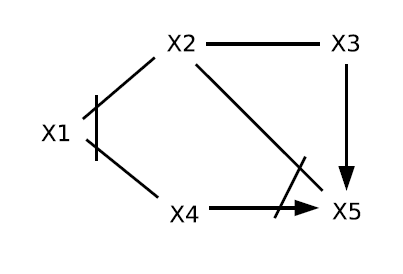 [6]

#### Generating the independence set which satisfies only Adjacency-Faithfulness

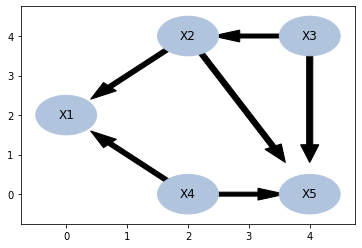

In [26]:
ptn = pattern()
ptn.add_edges([
    ('X2', 'X1'),
    ('X4', 'X1'),
    ('X4', 'X5'),
    ('X2', 'X5'),
    ('X4', 'X5'),
    ('X3', 'X2'),
    ('X3', 'X5')
])
pos = {
    'X1' : np.array([0, 2]),
    'X2' : np.array([2, 4]),
    'X4' : np.array([2, 0]),
    'X3' : np.array([4, 4]),
    'X5' : np.array([4, 0])
}
ptn.draw_by_pos(pos)

In [27]:
ds = ptn.get_all_d_separation()

In [28]:
ds['X2']['X4'].add(tuple(['X1']))
ds['X2']['X4'].add(tuple(['X5']))
ds['X2']['X4']

{(), ('X1',), ('X3',), ('X5',)}

#### CPC

In [29]:
cpc_al = cpc()
cpc_al.identify(ind = ds)

In [30]:
cpc_al.unfaithful_triple

{('X2', 'X1', 'X4'),
 ('X2', 'X5', 'X4'),
 ('X4', 'X1', 'X2'),
 ('X4', 'X5', 'X2')}

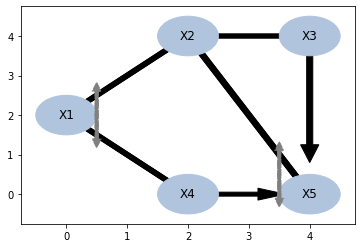

In [31]:
cpc_al.draw_by_pos(pos)

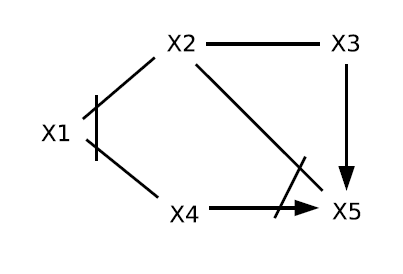

### Reference

[6] Ramsey, J., Spirtes, P., &#38; Zhang, J. (2006). Adjacency-faithfulness and conservative causal inference. <i>Proceedings of the 22nd Conference on Uncertainty in Artificial Intelligence, UAI 2006</i>.